In [44]:
import csv
import networkx as nx 
import numpy as np
import pandas as pd 
import community 
import matplotlib.pyplot as plt 
import seaborn as sns
from seaborn import color_palette, set_style, palplot
plt.style.use('ggplot')
%matplotlib inline

In [45]:
## read pre-processed data from stata
df = pd.read_stata('data/0_CPIS_CDIS_BIS_USTIC_merged_fixed1.dta')
df.columns.values

array(['country', 'countrycode', 'counterpart', 'counterpart_code', 'year',
       'CDIS_IADE', 'CDIS_IADD', 'CDIS_IAD', 'CDIS_IADF', 'CPIS_IAP',
       'CPIS_IAPE', 'CPIS_IAPD', 'loans_dep', 'total_claims'], dtype=object)

In [46]:
keep_var = ['countrycode','counterpart_code','country','counterpart','CDIS_IAD','CPIS_IAP','loans_dep']
df_2015 = df[df['year']==2015][keep_var]
df_2015.fillna(0,inplace=True)
df_2015.loc[df['CDIS_IAD']<0,'CDIS_IAD'] = 0                       # recode all negative values to 0 
df_2015.loc[df['CPIS_IAP']<0,'CPIS_IAP'] = 0                       # recode negative values to 0 

In [47]:
df_2015['total']=df_2015.CDIS_IAD + df_2015.CPIS_IAP+df_2015.loans_dep
df_2015 = df_2015[df_2015.total>0]

In [48]:
df_2015.describe()

,countrycode,counterpart_code,CDIS_IAD,CPIS_IAP,loans_dep,total
count,11483.000000,11483.000000,11483.000000,1.148300e+04,1.148300e+04,1.148300e+04
mean,441.917267,458.229218,2264.462891,3.046547e+03,1.892290e+03,7.203310e+03
std,286.768341,299.037659,19392.126953,2.868603e+04,2.275928e+04,5.916372e+04
min,111.000000,111.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e-12
25%,172.000000,174.000000,0.000000,0.000000e+00,0.000000e+00,3.000000e+00
50%,377.000000,423.000000,0.261265,0.000000e+00,2.000000e+00,3.489690e+01
75%,656.000000,686.000000,58.320295,3.748796e+01,7.100000e+01,4.629932e+02
max,968.000000,968.000000,618884.562500,1.464027e+06,1.221732e+06,2.539732e+06


In [49]:
## see how mancy countries we have
print(df_2015['country'].unique().shape)
print(df_2015['counterpart'].unique().shape)

(228,)
(228,)


## Load network

In [50]:
## read from pandas datafrme 
G = nx.from_pandas_dataframe(df_2015, source="country", target="counterpart", edge_attr=['total'],create_using=nx.DiGraph()) ##,'CPIS_IAP','loans_dep'

In [51]:
# print out one particular edge, just to make sure it wroks 
G['United States']['United Kingdom']

{'total': 2539732.0}

In [52]:
# make sure the graph is created correctly 
df_2015[(df_2015.country == 'United States') & (df_2015.counterpart == 'United Kingdom')]

,countrycode,counterpart_code,country,counterpart,CDIS_IAD,CPIS_IAP,loans_dep,total
2787,111.0,112.0,United States,United Kingdom,605312.0,958256.0,976164.0,2539732.0


In [53]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 229
Number of edges: 11483
Average in degree:  50.1441
Average out degree:  50.1441


In [54]:
## density 
nx.density(G)

0.21993028422584845

## Diameter and radius

## Explore Degrees 

/home/ubuntu/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


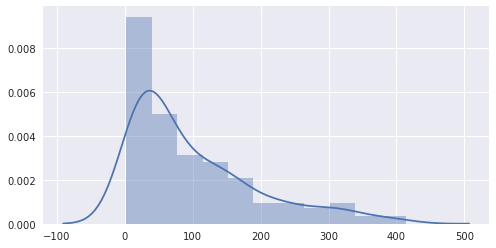

In [55]:
# Degree distribution
k = G.degree()
k =np.array(list(k.values()))
sns.set(rc={"figure.figsize": (8, 4)})
ax = sns.distplot(k)

In [56]:
# Find nodes with highest degree, unweighted 
k=G.degree()                                 ## get the degree centrality for all countries 
k = pd.DataFrame(list(k.items()),columns=['country','degree'])      ## make it into dataframe
k.sort_values(by='degree',ascending=0,inplace=True)                 ## sort it 
print('unweighted:')
k.head(5)

unweighted:


,country,degree
116,Italy,414
80,United Kingdom,397
109,France,380
36,Switzerland,375
160,Belgium,355


## Centrality measures

In [57]:
### Weighted degree centrality 
### This is the sum of both in and out folows 
d=nx.degree_centrality(G)                                 ## get the degree centrality for all countries 
degree = pd.DataFrame(list(d.items()),columns=['country','degree'])      ## make it into dataframe
degree.sort_values(by='degree',ascending=0,inplace=True)                 ## sort it 
degree.head(10)
## because it is a directd graph, centrality will be between 0,2

,country,degree
116,Italy,1.815789
80,United Kingdom,1.741228
109,France,1.666667
36,Switzerland,1.644737
160,Belgium,1.557018
210,Luxembourg,1.513158
35,United States,1.482456
113,India,1.412281
34,Netherlands,1.399123
172,Jersey,1.399123


In [58]:
## closeness
## nx.shortest_path_length(G)['United States']
c=nx.closeness_centrality(G)#distance ='rev_CDIS_IAD'                                  ## use CDIS_IAD data as distance mearuse, so the order should be reversed
closeness = pd.DataFrame(list(c.items()),columns=['country','closeness'])      ## make it into dataframe
closeness.sort_values(by='closeness',ascending=0,inplace=True)    
closeness.head(10)

,country,closeness
116,Italy,0.926247
80,United Kingdom,0.869248
109,France,0.865917
217,"Korea, Republic of",0.818856
36,Switzerland,0.815900
210,Luxembourg,0.801434
160,Belgium,0.782022
34,Netherlands,0.766117
175,Ireland,0.753348
190,Austria,0.743435


In [59]:
## betweeness 
b = nx.betweenness_centrality(G)  # weight='total'
between = pd.DataFrame(list(b.items()),columns=['country','between'])      ## make it into dataframe
between.sort_values(by='between',ascending=0,inplace=True)    
between.head(10)

,country,between
116,Italy,0.102553
80,United Kingdom,0.061512
109,France,0.048611
36,Switzerland,0.047991
35,United States,0.037320
160,Belgium,0.032046
210,Luxembourg,0.031884
208,Thailand,0.029482
113,India,0.026257
217,"Korea, Republic of",0.025296


In [60]:
## eigenvector centrality 
e = nx.eigenvector_centrality_numpy(G,weight='total')
eigenvector = pd.DataFrame(list(e.items()),columns=['country','total'])      ## make it into dataframe
eigenvector.sort_values(by='total',ascending=0,inplace=True)    
eigenvector.head(10)

,country,total
35,United States,0.533072
80,United Kingdom,0.515078
34,Netherlands,0.279140
109,France,0.250279
218,Germany,0.250142
123,Cayman Islands,0.219906
210,Luxembourg,0.197631
175,Ireland,0.152826
50,Canada,0.145663
167,Spain,0.145250


In [61]:
## does not work for directed graph 
#partition = community.best_partition(G)

In [62]:
nx.write_gexf(G, "2015.gexf")

## Visualizations

#### 2009
<img src="pic/2009.png" width=500 hight=500></img>
#### 2015
<img src="pic/2015.png" width=500 hight=500></img>